# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [81]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [82]:
batch_size = 100
epochs = 5
learning_rate = 1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
#print layers, used for debugging
NNprint_ = False
classes = [0,1,2,3,4]
num_classes=len(classes)

### Import MNIST Dataset

In [83]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

In [84]:
# 1 Extract 100 labeled datapoints from MNIST (10 from each class).
def get_target_indexes(dset, classes, n_class_examples):
  """
  """
  idxs = []
  ts = []
  n_samples = n_class_examples * len(classes)

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_class_examples) and (x.numpy() in classes):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

In [85]:
idx_train_subset = get_target_indexes(dset_train, classes, 100)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=batch_size)

idx_test_subset = get_target_indexes(dset_test, classes, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=batch_size)

### Plot examples

In [86]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
image_channels = example_data.size(1)

def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros = torch.zeros(num_classes,1024)
                samples = torch.cat((torch.rand(latent_dim,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

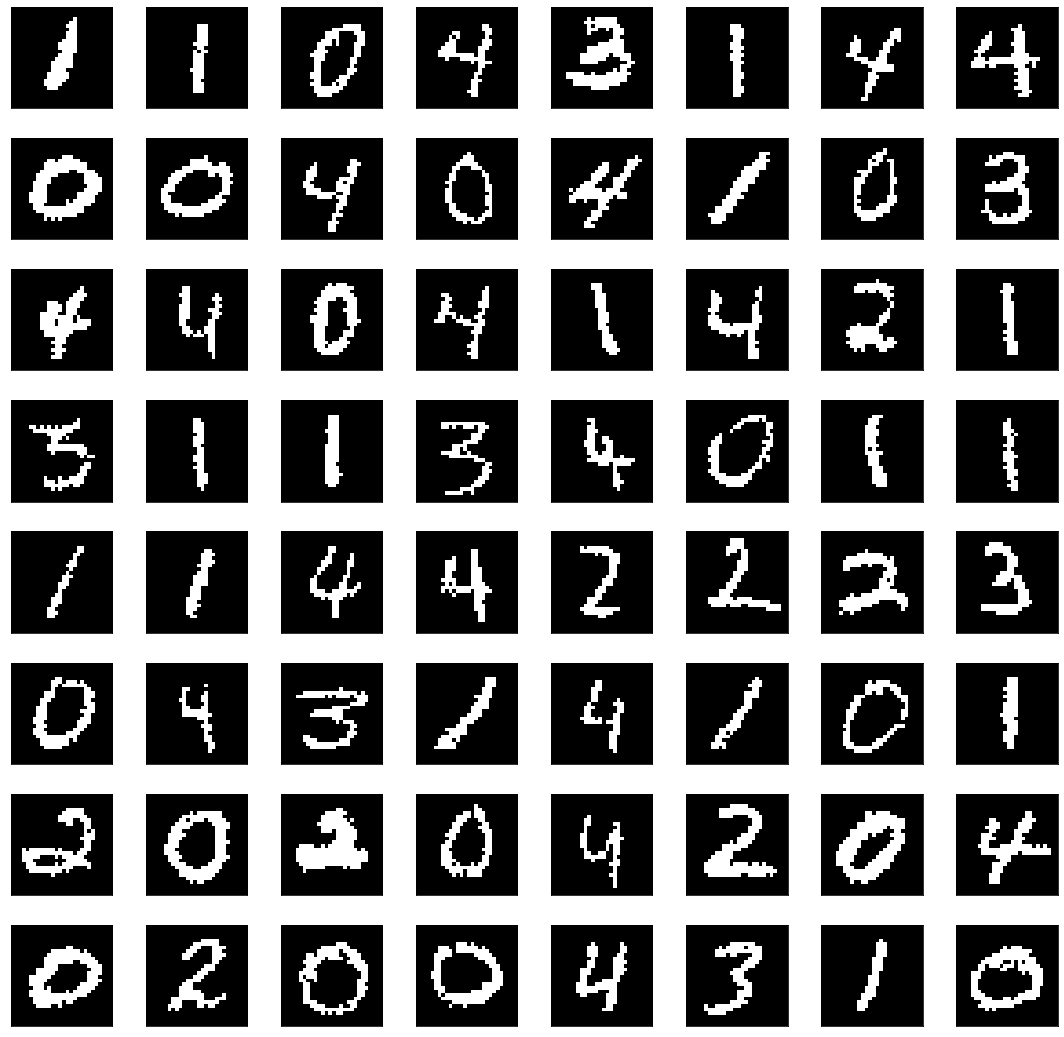

In [87]:
plot_examples()

### Torch auxiliary modules

In [88]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

    
class UnFlatten_FF(torch.nn.Module):
    def forward(self, input, size=784):
        return input.view(-1,1,28,28)
    
    
# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

# Semi-supervised Convolutional CVAE

In [89]:
class SS_CVAE_CONV(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32, num_labels=0):
        super(SS_CVAE_CONV, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            NNprint(),
        )

        self.h_dim = h_dim
        self.z_dim = z_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc2 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )

        # simple FFNN classifier
        # input: flattened vector, output: probability of each class
        # TODO: implement CNN classifier
        self.classifier = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(784, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.num_labels), # 3 output layer
            torch.nn.Softmax(dim=1)
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # TODO: Why do it like this?
        eps = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * eps.to(device)
        return z

    def encode(self, x, y):
        # pass x through conv encoder and flatten output to obtain h
        # n.b. normally [x,y] would be encoded, but this is not possible with a
        # CNN architecture
        h = self.encoder(x)

        # concat y (labels) to h, to place in latent space
        h = torch.cat((h, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)

        # fc1 encodes [h,y] into mu; fc2 encodes [h,y] into logvar
        mu, logvar = self.fc1(h), self.fc2(h) # use relu to prevent negative values
        
        return mu, logvar

    def decode(self, z, y):
        # concat y (labels) to z_lab, to place in latent space
        z = torch.cat((z, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)
        
        # upscale [z,y] to h_dim
        z = self.fc3(z)

        # decode upscaled [z,y] to x_recon
        x_recon = self.decoder(z)
        return x_recon
    
    def forward(self, x_labelled, x_unlabelled, y):
        # labeled case ########################################################
        # encode [x_labelled,y] to mu_lab and logvar_lab
        mu_lab, logvar_lab = self.encode(x_labelled, y)
        
        # sample z_lab using mu_lab and logvar_lab
        z_lab = self.reparameterize(mu_lab, logvar_lab)

        # decode [z_lab,y] to get reconstruction
        x_lab_recon = self.decode(z_lab, y)


        # classification ######################################################
        # labelled case - this is used for the classification objective loss
        y_labelled_pred = self.classifier(x_labelled)

        # unlabelled case - predict a y for the entropy term, H(q(y|x))
        y_unlabelled_pred = self.classifier(x_unlabelled)

        # unlabeled case ######################################################
        # integrate over y -- i.e. perform generation and inference for any 
        # possible class of y. Then calculate loss for any case
        # We do this by tiling x_unlabelled and y, then concat for parallelism

        # TODO: repeat copies the data, so there might be a less expensive way to do this
        x_unlab_tiled = x_unlabelled.repeat(self.num_labels,1,1,1)
        # tensor of class labels [0,1,2,3,4,5,6,7,8,9], repeated for number of datapoints as [0_0,0_1,0_n, ...]
        y_unlab_tiled = torch.repeat_interleave(torch.arange(self.num_labels), x_unlabelled.shape[0])

        # encode x_unlab and y_unlab to mu_unlab and logvar_unlab
        mu_unlab, logvar_unlab = self.encode(x_unlab_tiled, y_unlab_tiled)

        # sample z_unlab via mu_unlab and logvar_unlab
        z_unlab = self.reparameterize(mu_unlab, logvar_unlab)

        # decode [z_unlab,y_unlab] to get reconstruction
        x_unlab_recon = self.decode(z_unlab, y_unlab_tiled)

        # TODO: Find better solution
        return {'L' : (mu_lab, logvar_lab, z_lab, x_lab_recon, y_labelled_pred), \
                'U' : (mu_unlab, logvar_unlab, z_unlab, x_unlab_recon, y_unlabelled_pred)}
    
    def log_prob_gaussian(self, x, mu, log_sigma):
      eps = 1e-10 # TODO: handle more elegantly
      sigma = log_sigma.exp()
      logprob = -torch.log(sigma * np.sqrt(2*np.pi) + eps) - 0.5 * ((x - mu)/sigma)**2
      return logprob.view(logprob.size(0), -1).sum(dim=1) # equivalent to reduce_sum

    def L(self, x, x_recon, yp, z, mu, logvar):
      """Calculate -L(x,y)

      -L(x,y) is used to calculate loss for both the Labelled and Unlabelled case

      Formula:
        -L(x,y) = E_q(z|x,y) [ logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y) ]
      """
      # check if x_recon has been repeated for n classes and tile if necessary
      # n.b. this is only needed, because we are tiling, i.e. repeating the tensor
      # for each possible class of y, which enables integrating over y
      if (x.size(0) < x_recon.size(0)):
        factor = int(x_recon.size(0) / x.size(0))
        x = x.repeat(factor,1,1,1) # repeat for each class

      logpx = F.binary_cross_entropy(x_recon, x.to(device), size_average=False, reduction='sum')
      logpy = torch.log(yp)
      logpz = self.log_prob_gaussian(z, torch.zeros_like(z), torch.ones_like(z)) # logprob Gaussian for z, 0, I
      logqz = self.log_prob_gaussian(z, mu, logvar) # logprob Gaussian for z, mu, logvar
      
      return (logpx + logpy + logpz - logqz) # N.B. we don't take the mean here!

    def J_alpha(self, x_labelled, y_labelled, x_unlabelled, Ls, Us, a=.1):
      """Calculate loss as J_alpha

      J_alpha = J + alpha * C

      Where
        J = ∑L(x,y) + ∑U(x)
        -L(x,y) = E_q(z|x,y)[logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y)]
        -U(x) = ∑_y q(y|x)(-L(x,y)) + H(q(y|x))
        C = E_p(x,y) [-logq(y|x)]

      
      """
      # labelled loss ##########################################################
      mu, logvar = Ls[0], Ls[1]
      z = Ls[2]
      x_recon = Ls[3]
      # mean for expectation instead of sum
      Lxy = -torch.mean(self.L(x_labelled, x_recon, torch.Tensor([0.1]), z, mu, logvar)) # TODO: Is prob of y *just* 0.1?

      # unlabelled loss ########################################################
      mu, logvar = Us[0], Us[1]
      z = Us[2]
      x_recon = Us[3]
      y_pred = Us[4]
      # use list comprehension to get probabilities for class i for an entire batch
      # i.e. first probs for class == 0, then class == 1, etc.
      y_pred_tiled = torch.cat([y_pred[:,i] for i in range(self.num_labels)])
      # mean for expectation instead of sum
      Luxy = -torch.mean(self.L(x_unlabelled, x_recon, torch.Tensor([0.1]), z, mu, logvar))
      H = -torch.sum(y_pred * torch.log(y_pred))
      U = -(torch.sum(y_pred_tiled * Luxy) + H) # TODO: Split out U

      # classification loss ####################################################
      y = y_labelled
      y_labelled_pred = Ls[4]
      C = F.cross_entropy(y_labelled_pred, y, reduction='sum') # reduction 'mean' is deprecated TODO: What does this mean for the output?
      
      J = Lxy + U 
      Ja = J + a * C
      return Ja

    def sample(self, y):
        """Sample z, conditioning on y and reconstruct
        """
        # sample z ~ N(0,I)
        mu, logvar = torch.zeros((y.size(0),self.z_dim)), torch.ones(y.size(0),self.z_dim)
        z = self.reparameterize(mu, logvar)

        # decode sampled z with condition
        x_recon = self.decode(z, y.to(torch.int64))
        return x_recon

# test model
model = SS_CVAE_CONV(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
print("Model\n", model)

# test forward-pass
split_by = int(batch_size/10)
x_l = example_data[:split_by]
y_l = example_targets[:split_by]
x_u = example_data[split_by:]
out_fpass = model(x_l, x_u, y_l)

# test loss
loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
print("Loss\n", loss)

Model
 SS_CVAE_CONV(
  (encoder): Sequential(
    (0): NNprint()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): NNprint()
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): NNprint()
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): NNprint()
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): NNprint()
    (12): LeakyReLU(negative_slope=0.01)
    (13): Flatten()
    (14): NNprint()
  )
  (fc1): Linear(in_features=1029, out_features=8, bias=True)
  (fc2): Linear(in_features=1029, out_features=8, bias=True)
  (fc3): Linear(in_features=13, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): NNprint()
    (1): UnFlatten()
    (2): NNprint()
    (3): ConvTranspose2d(1024, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): NNprint()
    (6): ConvTra

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [90]:
model = SS_CVAE_CONV(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
        y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
        out_fpass = model(x_l.to(device), x_u.to(device), y_l)
        
        loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
            y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
            out_fpass = model(x_l.to(device), x_u.to(device), y_l)
            
            loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
            running_loss += loss

    return running_loss/len(test_loader.dataset)

In [92]:
train_loss = []
test_loss = []
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    print("\t Training ...")
    train_epoch_loss = fit_model(model, dset_train_subset_loader)
    print("\t Testing ...")
    test_epoch_loss = test_model(model, dset_test_subset_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

# torch.save(model.state_dict(), 'cvae.torch')


Epoch 1 of 5
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train Loss: 208803.9219
Val Loss: 175776.5156
Epoch 2 of 5
	 Training ...
	 Testing ...
Train Loss: 161543.2031
Val Loss: 127300.4375
Epoch 3 of 5
	 Training ...
	 Testing ...
Train Loss: 117815.8984
Val Loss: 97940.6016
Epoch 4 of 5
	 Training ...
	 Testing ...
Train Loss: 96534.5781
Val Loss: 89345.6953
Epoch 5 of 5
	 Training ...
	 Testing ...
Train Loss: 89046.2891
Val Loss: 84575.8281


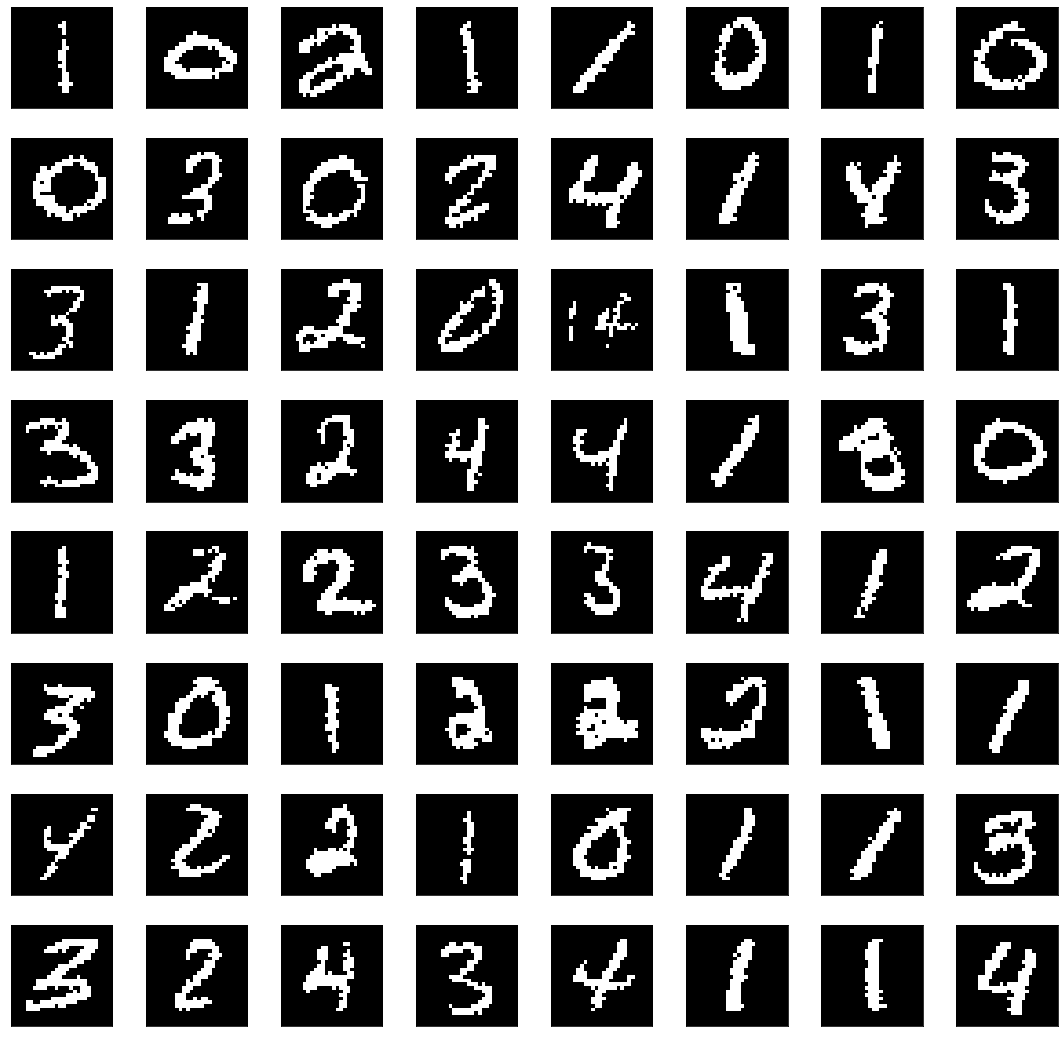

In [93]:
plot_examples()

In [ ]:
#Reconstructions
plot_examples(model) 

TypeError: ignored

In [ ]:
# Sample latent space
plot_examples(model,sample=True)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 model from Semi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

1. Extract 100 labeled datapoints from MNIST (10 from each class).
2.(Report) Train a classifier on their latent representation.  First try a linear classifier and then experiment with other types of classifiers.  Report the accuracies.
3.(Report) Implement  some  simple  baselines:  Train  a  linear  classifier  or  neural  network  from scratch using only the 100 labeled data points.  Report the accuracies.

In [ ]:
# 0 Train VAE on all available data (X), without labels (y)

model = CVAE(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
##
train_loss = []
test_loss = []
epochs=5
learning_rate=1e-3

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

# torch.save(model.state_dict(), 'cvae.torch')

Epoch 1 of 5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Loss: 117.6458
Val Loss: 91.3892
Epoch 2 of 5
Train Loss: 80.4845
Val Loss: 64.7040
Epoch 3 of 5
Train Loss: 55.2358
Val Loss: 48.9142
Epoch 4 of 5
Train Loss: 47.4716
Val Loss: 45.3025
Epoch 5 of 5
Train Loss: 44.6698
Val Loss: 43.1558


In [ ]:
# 1 Extract 100 labeled datapoints from MNIST (10 from each class).

def get_target_indexes(dset, n_class_examples):
  idxs = []
  ts = []
  n_samples = n_class_examples * len(np.unique(dset_train.targets.numpy()))

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_class_examples):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

# np.unique(dset_train.targets[idxs].numpy(), return_counts=True)
# torch.utils.data.Subset(dset_train, idxs)

In [ ]:
idx_train_subset = get_target_indexes(dset_train, 10)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=1000)

In [ ]:
idx_test_subset = get_target_indexes(dset_test, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=100)

In [ ]:
# 2 (Report) Train a classifier on their latent representation. 
# First try a linear classifier and then experiment with other types of classifiers. Report the accuracies.

from sklearn.linear_model import LogisticRegression

model.eval()

X_train = None

with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_train_subset_loader):
        recon_images, mu, logvar = model(images.to(device), None)
        X_train = mu.numpy()

y_train = dset_train.targets[idx_train_subset]
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("Loss (train): ", clf.score(X_train, y_train))

Loss (train):  0.94


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X_test = None
err = []
with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_test_subset_loader):
        recon_images, mu, logvar = model(images.to(device), None)
        X_test = mu.numpy()
        y_test = labels.numpy()
        err.append(clf.score(X_test, y_test))

print("Mean loss (test): ", np.mean(np.array(err)))

[0.66, 0.59, 0.68, 0.58, 0.64, 0.62, 0.56, 0.69, 0.66, 0.54]
Mean loss (test):  0.622


In [ ]:
# 

z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
z3 = torch.randn(1, latent_dim).to(device)
z4 = torch.randn(1, latent_dim).to(device)

y = torch.randint(0, 10,(1,1)).to(dtype=torch.long) # 10=number of classes
y = torch.nn.functional.one_hot(y,10).type(torch.float).to(device,dtype=z.dtype)[0]

z1 = torch.cat((z1,y),dim=1)
z2 = torch.cat((z2,y),dim=1)
z3 = torch.cat((z3,y),dim=1)
z4 = torch.cat((z4,y),dim=1)

print(z1)
print(z2)
print(z3)
print(z4)
rec1 = model.decode(z1)
rec2 = model.decode(z2)
rec3 = model.decode(z3)
rec4 = model.decode(z4)

img1 = rec1.view(28,28).data
img2 = rec2.view(28,28).data
img3 = rec3.view(28,28).data
img4 = rec4.view(28,28).data


In [ ]:
plt.figure()
plt.imshow(img1.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img2.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img3.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img4.to('cpu'), cmap='gray')